# PF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l63 import lorenz63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.pf import ParticleFilter as PF

In [3]:
# params
s = 10
b = 8/3
r = 28

# time step size
dt = 0.01

# obs_per
obs_per = 6

# Dt: 時間刻み
# NOTE: nature runの生成に使ったdtに対して，Dt = dt * obs_perとなるように設定．
Dt = dt * obs_per

p = (s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, Dt):
    for i in range(int(Dt/dt)): # assume Dt = dt * int
        x = rk4(lorenz63, 0, x, p, dt)
    return x


# 真の時系列生成
# 初期値の設定
x0 = np.array([1., 1., 1.])

p = (s, r, b)
N = 4000*12 + 200
result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1, N):
    # t = n*dt
    x = M(x, dt)
    result[n] = x[:]

x_true_full = result[200:]

np.save(f"x_true_l63_full", x_true_full)

# 単位行列
I = np.eye(3, dtype=float)

# 観測
H = I
# H = np.eye(2,3)
# H = np.eye(1,3)
print("H:", H)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1
R = r**2*I

# 観測値と真値
end_step = 1000*obs_per # 開発用
x_true = np.load("x_true_l63_full.npy")[:end_step:obs_per]


R = H@R@H.T

# ensemble size
m = 60

# generate initial ensemble
seed = 0
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]
P_0 = 64*I

X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)

# inflation
sigma_add = 0.1


H: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [4]:
# generate observations
y = (H@x_true.T).T
y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y))

def h(x):
    return H@x

# assimilate
resampling_options = ["multinomial", "systematic", "residual"]
pf_results = {}
for opt in resampling_options:
    print(opt + " resampling")
    pf = PF(M, h, R, N_thr=.95, add_inflation=sigma_add, resample_option=opt)
    pf.initialize(X_0)

    for y_obs in tqdm(y[:end_step]):
        pf.forecast(Dt)
        pf.update(y_obs)

        if False:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            ax.scatter(*y_obs, marker='*')
            for x in pf.X:
                ax.scatter(*x)

            ax.set_xlim([-20, 20])
            ax.set_ylim([-20, 20])
            ax.set_zlim([-20, 20])
            plt.show()
    
    pf_results[opt] = pf

multinomial resampling


100%|██████████| 1000/1000 [00:03<00:00, 305.36it/s]


systematic resampling


100%|██████████| 1000/1000 [00:03<00:00, 296.44it/s]


residual resampling


100%|██████████| 1000/1000 [00:03<00:00, 295.24it/s]


observation
RMSE time average: 0.9394681752869353
---
multinomial resampling
RMSE time average: 0.24838171901509926
---
systematic resampling
RMSE time average: 0.3126427586719874
---
residual resampling
RMSE time average: 0.3036264090129705


Text(0.5, 1.0, 'RMSE')

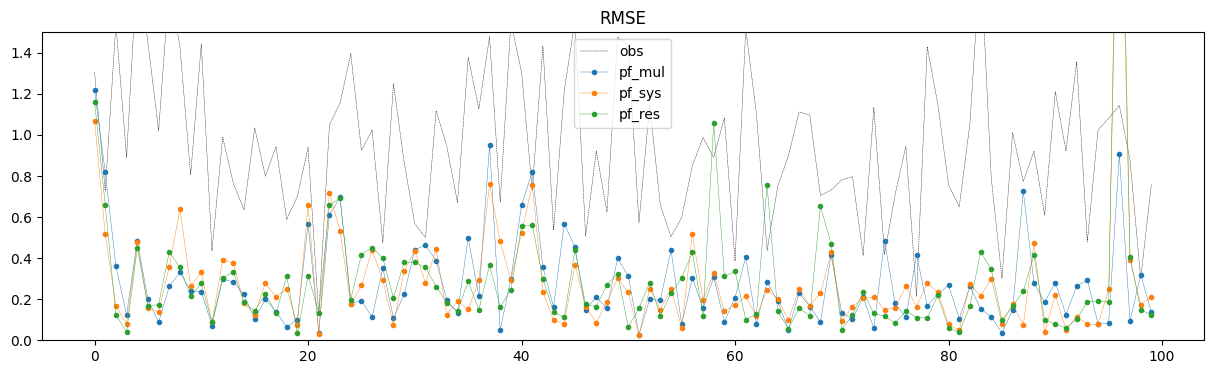

In [5]:
# plot rmse
vis_per = 10
fig, ax = plt.subplots(figsize=(15, 4))
plot_loss(x_true[:end_step:vis_per]@H.T, y[:end_step:vis_per], loss_rms, ax=ax, label='obs', lw=0.3, ls="dashed", color="black")
print("observation")
print("RMSE time average:", loss_rms(x_true[:end_step:vis_per]@H.T, y[:end_step:vis_per]).mean())
for opt, pf in pf_results.items():
    print("---")
    print(opt + " resampling")
    plot_loss(x_true[:end_step:vis_per], pf.x[:end_step:vis_per], loss_rms, ax=ax, label='pf_' + opt[:3], lw=0.3, marker=".")
    print("RMSE time average:", loss_rms(x_true[:end_step], pf.x)[len(pf.x)//4*3:].mean())
    # print("ESS:", pf._caluculate_eff(pf.W))

ax.legend()
ax.set_ylim([0, 1.5*r])
ax.set_title("RMSE")

# m vs. sigma

In [6]:
def compute_rmse(simulate_params):
    m, sigma = simulate_params.values()
    # RUN DA
    pf = PF(M, h, R, add_inflation=sigma, N_thr=.9)
    X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
    pf.initialize(X_0)
    for y_obs in tqdm(y):
        pf.forecast(Dt)
        pf.update(y_obs)

    return loss_rms(x_true, pf.x).mean()

In [7]:
# from da.params import prod_params_kv
from da.optimize import grid_search2
import seaborn as sns

m_list = [20, 40, 60]
sigma_list = [0.1, 0.2, 0.4]

# params_kv = prod_params_kv("m", m_list, "sigma", sigma_list)
# print(params_kv)

# df = grid_search2(compute_rmse, "m", m_list, "sigma", sigma_list, n_multi=1, multi_type="process")
# sns.heatmap(df, annot=True, fmt=".3g", vmax=r*1.5, vmin=max([0.0, r-1.0]))